# Introduction
Prostate cancer is cancer that occurs in the prostate — a small walnut-shaped gland in men that produces the seminal fluid that nourishes and transports sperm.

Prostate cancer is one of the most common types of cancer in men. Usually prostate cancer grows slowly and is initially confined to the prostate gland, where it may not cause serious harm. However, while some types of prostate cancer grow slowly and may need minimal or even no treatment, other types are aggressive and can spread quickly

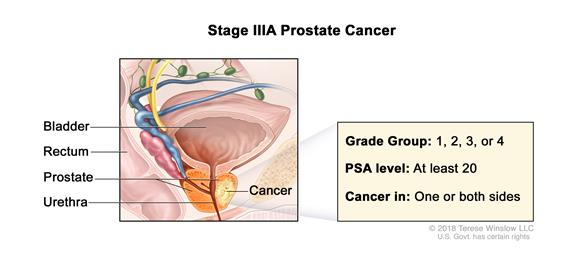

In [ ]:
import sys
import os
import subprocess
from six import string_types

# Make sure you have all of these packages installed, e.g. via pip
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
from skimage import io
from scipy import ndimage
import rasterio
import openslide
from IPython.display import display
import os
from tqdm.auto import tqdm 
import PIL
from IPython.display import Image, display
import plotly.graph_objs as go
sns.set_style("darkgrid")
# import the necessary packages
%matplotlib inline

In [ ]:
ROOT = "/kaggle/input/prostate-cancer-grade-assessment/"
!ls {ROOT}

In [ ]:
# image and mask directories
data_dir = f'{ROOT}/train_images'
mask_dir = f'{ROOT}/train_label_masks'

# Gleason Score

The Gleason Score is the grading system used to determine the aggressiveness of prostate cancer. ... The Gleason Score ranges from 1-5 and describes how much the cancer from a biopsy looks like healthy tissue (lower score) or abnormal tissue (higher score). Most cancers score a grade of 3 or higher.

A Video has been attached that , will show the **Gleason Score** https://www.youtube.com/watch?v=1Q7ERNtLcvk

# Grade Group?
In 2014, the International Society of Urological Pathologists released supplementary guidance and a revised prostate cancer grading system, called the Grade Groups.

The Grade Group system is simpler, with just five grades, 1 through 5.

<table class="table table-striped table-hover">
<thead>
<tr>
<th><b>Risk Group</b></th>
<th><b>Grade Group</b></th>
<th><b>Gleason Score</b></th>
</tr>
</thead>
<tbody>
<tr>
<td>Low</td>
<td>Grade Group 1</td>
<td>Gleason Score ≤ 6</td>
</tr>
<tr>
<td>Intermediate Favorable</td>
<td>Grade Group 2</td>
<td>Gleason Score 7 (3 + 4)</td>
</tr>
<tr>
<td>Intermediate Unfavorable</td>
<td>Grade Group 3</td>
<td>Gleason Score 7 (4 + 3)</td>
</tr>
<tr>
<td>High</td>
<td>Grade Group 4</td>
<td>Gleason Score 8</td>
</tr>
<tr>
<td>High</td>
<td>Grade Group 5</td>
<td>Gleason Score 9-10</td>
</tr>
</tbody>
</table>

In [ ]:
train_path = ROOT + "train.csv"
train_df = pd.read_csv(train_path)

In [ ]:
train_df.head()


In [ ]:
print("shape : ", train_df.shape)
print("unique data provider : ", len(train_df.data_provider.unique()))
print("unique isup_grade(target) : ", len(train_df.isup_grade.unique()))
print("unique gleason_score : ", len(train_df.gleason_score.unique()))

# target Distribution

In [ ]:
ax = sns.countplot(x="isup_grade", data=train_df)
plt.title("target distribution")
plt.show()

In [ ]:
ax = sns.countplot(x="data_provider", data=train_df)
plt.title("Data Provider")
plt.show()

In [ ]:
fig= plt.figure(figsize=(10,6))
ax = sns.countplot(x="isup_grade", hue="data_provider", data=train_df)
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
sns.countplot(ax=ax1, y="gleason_score", data=train_df)
sns.countplot(ax=ax2, y="gleason_score",hue='data_provider', data=train_df)
plt.tight_layout()
plt.title("counts of different gleason_score")
plt.show()

# Reading Image File

In [ ]:
path = '/kaggle/input/prostate-cancer-grade-assessment/train_images/0005f7aaab2800f6170c399693a96917.tiff'
src = rasterio.open(path)

In [ ]:
src.name
array = src.read(1)

In [ ]:
array

In [ ]:
from matplotlib import pyplot
pyplot.imshow(array)
pyplot.show()  

# Reading A Train Mask Image

In [ ]:
train_label_masks = '/kaggle/input/prostate-cancer-grade-assessment/train_label_masks/00412139e6b04d1e1cee8421f38f6e90_mask.tiff'
src = rasterio.open(train_label_masks)
src.name
array = src.read(1)
pyplot.imshow(array)
pyplot.show()  

# Display Images together

In [ ]:
files = os.listdir(ROOT+"train_images/")
print(f"there are {len(files)} tiff files in train_images folder")
for i in train_df.image_id:
    assert i+".tiff" in files
print("all training image_ids have their files in train_images folder")

In [ ]:
slide = openslide.OpenSlide(ROOT+"train_images/"+files[0])
spacing = 1 / (float(slide.properties['tiff.XResolution']) / 10000)
print(f"File id: {slide}")
print(f"Dimensions: {slide.dimensions}")
print(f"Microns per pixel / pixel spacing: {spacing:.3f}")
print(f"Number of levels in the image: {slide.level_count}")
print(f"Downsample factor per level: {slide.level_downsamples}")
print(f"Dimensions of levels: {slide.level_dimensions}")
patch = slide.read_region((1780,1950), 0, (256, 256))
display(patch) # Display the image
slide.close()

In [ ]:
dims, spacings, level_counts = [], [], []
down_levels, level_dims = [], []

# train = train.sample(300)
for i in tqdm(train_df.image_id, leave=False):
    slide = openslide.OpenSlide(ROOT+"train_images/"+i+".tiff")
    spacing = 1 / (float(slide.properties['tiff.XResolution']) / 10000)
    dims.append(slide.dimensions)
    spacings.append(spacing)
    level_counts.append(slide.level_count)
    down_levels.append(slide.level_downsamples)
    level_dims.append(slide.level_dimensions)
    slide.close()
    del slide

In [ ]:
train_df['width']  = [i[0] for i in dims]
train_df['height'] = [i[1] for i in dims]
train_df['spacing'] = spacings
train_df['level_count'] = level_counts


In [ ]:
fig = plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='width', y='height', data=train_df, alpha=0.3)
plt.title("height(y) width(x) scatter plot")
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='width', y='height', hue='isup_grade', data=train_df, alpha=0.6)
plt.title("height(y) width(x) scatter plot with target")
plt.show()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))
sns.countplot(ax=ax1, x=train_df['level_count'])
ax1.set_title("level counts")
sns.distplot(ax=ax2, a=[j for i in down_levels for j in i], bins=12, kde=False)
ax2.set_title("down level")
sns.distplot(ax=ax3, a=train_df['spacing'], kde=False)
ax2.set_title("spacing distribution")
plt.show()

In the following sections we will load data from the slides with OpenSlide. The benefit of OpenSlide is that we can load arbitrary regions of the slide, without loading the whole image in memory. Want to interactively view a slide? We have added an interactive viewer to this notebook in the last section.

In [ ]:
def display_images(slides):     
    for slide in slides:
        image = openslide.OpenSlide(os.path.join(data_dir, f'{slide}.tiff'))
        spacing = 1 / (float(image.properties['tiff.XResolution']) / 10000)
        patch = image.read_region((1780,1950), 0, (256, 256))
        display(patch) # Display the image
        
        print(f"File id: {slide}")
        print(f"Dimensions: {image.dimensions}")
        print(f"Microns per pixel / pixel spacing: {spacing:.3f}")
        print(f"Number of levels in the image: {image.level_count}")
        print(f"Downsample factor per level: {image.level_downsamples}")
        print(f"Dimensions of levels: {image.level_dimensions}")
        
        image.close()

In [ ]:
images = [
    '005e66f06bce9c2e49142536caf2f6ee',
    '001c62abd11fa4b57bf7a6c603a11bb9',
    '000920ad0b612851f8e01bcc880d9b3d'
]

display_images(images)